<a href="https://colab.research.google.com/github/samuelagyemang2012/autoencoder_intro/blob/master/Autoencoders_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow.keras
from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist
import gzip
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dense,Reshape
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from scipy import spatial
from scipy.spatial import distance

In [ ]:
# fetch MNIST data
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
# Convert to float
trainX = trainX.astype('float32')
testX = testX.astype('float32')

In [ ]:
# Normalize data
trainX = trainX/255
testX = testX/255

In [ ]:
# Reshape data
trainX = trainX.reshape(-1,28,28, 1)
testX = testX.reshape(-1, 28,28, 1)

print(trainX.shape)
print(trainX.shape)

(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [ ]:
# Create label dict
label_dict = {
    0:"T-shirt",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle Boot",
}

In [ ]:
input_shape = (28,28,1)
latent_shape = (7,7,128)

In [ ]:
def encoder(size, channel):
  encoder = Sequential()

  encoder.add(Input(shape = input_shape))                                #28x28x1
  encoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))     #28x28x32
  encoder.add(MaxPooling2D(pool_size=(2, 2)))                            #14x14x32
  encoder.add(Conv2D(64, (3,3), activation='relu', padding='same'))      #14x14x64
  encoder.add(MaxPooling2D(pool_size=(2,2)))                             #7x7x64
  encoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))    #7x7x128
  encoder.add(Flatten())                                                 #7x7x128 = 6272
  encoder.add(Dense(128, activation="relu"))                             #128

  return encoder

def decoder():
  
  decoder = Sequential()

  decoder.add(Input(shape=(128,)))                                       # 128
  decoder.add(Dense(6272, activation="relu"))                            # 6272
  decoder.add(Reshape((7,7,128)))                                        # 7 x 7 x 128
  decoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))    # 7 x 7 x 128
  decoder.add(UpSampling2D((2,2)))                                       # 14 x 14 x 128
  decoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))     # 14 x 14 x 64
  decoder.add(UpSampling2D((2,2)))                                       # 28 x 28 x 64
  decoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))   # 28 x 28 x 1
  
  return decoder

def build_autoencoder(encoder, decoder):
  autoencoder = Sequential()
  autoencoder.add(Input(shape= input_shape))
  autoencoder.add(encoder)
  autoencoder.add(decoder)

  return autoencoder


In [ ]:
en = encoder(28,1)
en.summary()

de = decoder()
de.summary()

autoencoder = build_autoencoder(en, de)

# # Compile model
autoencoder.compile(loss='mean_squared_error', optimizer = "rmsprop")
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8

In [ ]:
BATCH_SIZE=128
EPOCHS = 20

history = autoencoder.fit(trainX, 
                          trainX, 
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          verbose=1,
                          validation_data=(testX, testX)
                          # validation_split=0.3
                          )

Epoch 1/20
469/469 [==============================] - 41s 16ms/step - loss: 0.0515 - val_loss: 0.0175
Epoch 2/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0169 - val_loss: 0.0136
Epoch 3/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0130 - val_loss: 0.0121
Epoch 4/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0110 - val_loss: 0.0111
Epoch 5/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0098 - val_loss: 0.0093
Epoch 6/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 7/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 8/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 9/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 10/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0073 - val_l

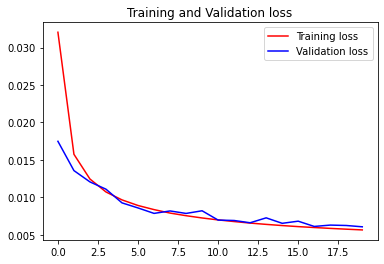

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, loss, label='Training loss', color="red")
plt.plot(epochs, val_loss, label='Validation loss', color="blue")
plt.title('Training and Validation loss')
plt.legend()
plt.show()


In [ ]:
# reconstructed images by autoencoder
preds = autoencoder.predict(testX)

In [ ]:
# latent representation of images with dimension of 128 by encoder. will be decoded by the decoder
encodings = en.predict(testX)

Text(0.5, 1.0, 'reconstructed')

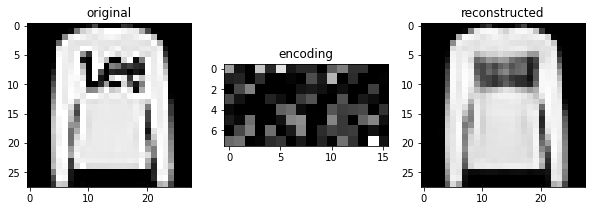

In [ ]:
index = 1

# create figure
fig = plt.figure(figsize=(10, 5))

# decode an encoding
dd = de.predict(encodings[index].reshape(-1, 128))

#add a subplot a 1st pos
fig.add_subplot(1, 3, 1) #rows, columns, position
plt.imshow(testX[index].reshape(28,28), cmap="gray")
plt.title("original")

#add a subplot a 2nd pos
fig.add_subplot(1, 3, 2) #rows, columns, position
plt.imshow(encodings[index].reshape(8,16), cmap="gray")
plt.title("encoding")

#add a subplot a 3rd pos
fig.add_subplot(1, 3, 3) #rows, columns, position
plt.imshow(dd.reshape(28,28), cmap="gray")
plt.title("reconstructed")



In [ ]:
# Calculate cosine similarity and euclidean distance between test image and reconstructed image

img1 = testX[index].reshape(-1)
img2 = dd.reshape(-1)

dist = distance.euclidean(img1, img2)
cosim =  1 - spatial.distance.cosine(img1, img2)

print("Euclidean distance: "+ str(round(dist,2))) # closer to 0, the more similar (shortest distance)
print("Cosine Similarity: "+ str(round(cosim,2))) # closer the to 1 the more similar

Euclidean distance: 3.58
Cosine Similarity: 0.98


In [ ]:
num=20

Original images


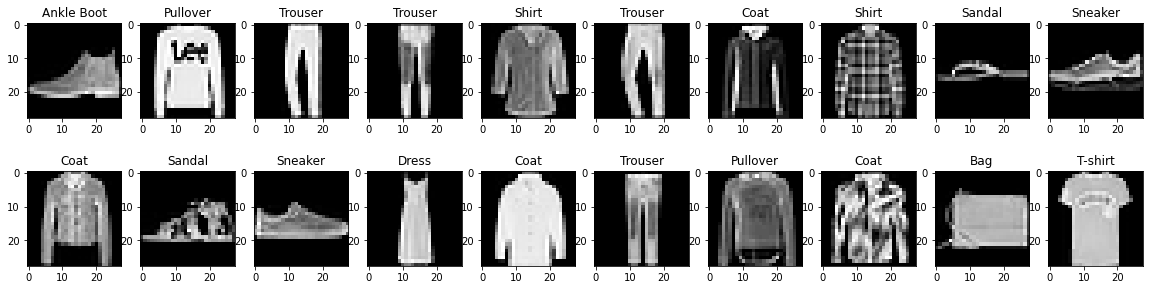

In [ ]:
print("Original images")
plt.figure(figsize=(20, 5))

for i in range(num):

  test_data = testX[i].reshape(28,28)
  
  plt.subplot(2, 10, i+1)
  plt.imshow(test_data, cmap="gray")
  plt.title(str(label_dict[testY[i]]))



Encodings


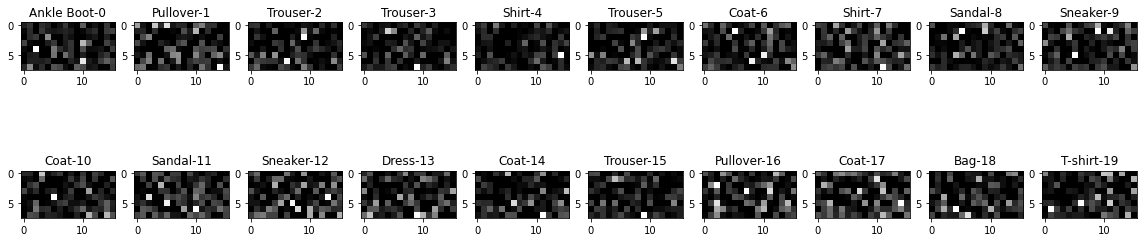

In [ ]:
print("Encodings")
plt.figure(figsize=(20, 5))

for i in range(num):
 
  plt.subplot(2,10,i+1)
  plt.imshow(encodings[i].reshape(8,16), cmap="gray")
  plt.title(str(label_dict[testY[i]])+"-"+str(i))

Reconstructed


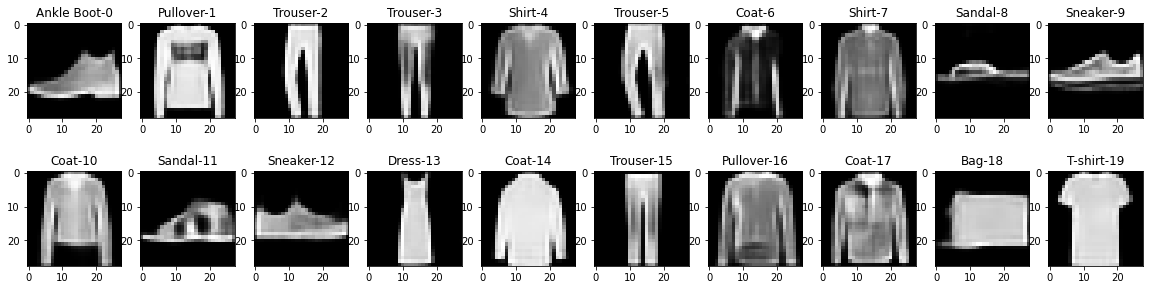

In [ ]:
print("Reconstructed")
plt.figure(figsize=(20, 5))

for i in range(num):
 
  recon_data = preds[i].reshape(28,28)

  plt.subplot(2,10,i+1)
  plt.imshow(recon_data, cmap="gray")
  plt.title(str(label_dict[testY[i]])+"-"+str(i))
